In [28]:
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
import math
import torch
import gpytorch
from scipy.stats import norm
import random

In [29]:

directory = "C:\\Users\\ssathe\\VSCode-Projects\\Nigel_Dataset_Processing\\AutoDRIVE-Nigel-Dataset-main\\2D_maneuvers"
def process_data(directory, dt):
    trajectories = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        
        # checking if it is a file
        # f = filename
        # print(f)
        if os.path.isfile(f):
            #print(f)
            with open(f, newline='') as csvfile:
                filereader = csv.reader(csvfile, delimiter=',', quotechar='|')
                tr = []
                for row in filereader:
                    throttle = float(row[1])
                    delta = float(row[2])
                    x = float(row[5])
                    y = float(row[6])
                    theta = float(row[10])
                    tr.append([throttle, delta, x, y, theta])
                tr = np.array(tr)
        trajectories.append(tr)
    dataset = []
    for trajectory in trajectories:
        # x = trajectory[:,2].reshape((-1,1))
        # y = trajectory[:,3].reshape((-1,1))
        # theta = trajectory[:,4].reshape((-1,1))
        # throttle = trajectory[:,0].reshape((-1,1))
        # delta = trajectory[:,1].reshape((-1,1))
        # xdot = ((np.diff(x, axis = 0))/(dt)).reshape((-1,1))
        # ydot = ((np.diff(y, axis = 0))/(dt)).reshape((-1,1))
        # thetadot = ((np.diff(theta, axis = 0))/(dt)).reshape((-1,1))
        # c = np.hstack((x[:-1,:], y[:-1,:], theta[:-1,:], throttle[:-1,:], delta[:-1,:], xdot, ydot, thetadot))

        x = trajectory[:-1,2].reshape((-1,1))
        y = trajectory[:-1,3].reshape((-1,1))
        theta = trajectory[:-1,4].reshape((-1,1))
        throttle = trajectory[:-1,0].reshape((-1,1))
        delta = trajectory[:-1,1].reshape((-1,1))
        x1 = trajectory[1:,2].reshape((-1,1))
        y1 = trajectory[1:,3].reshape((-1,1))
        theta1 = trajectory[1:,4].reshape((-1,1))
        c = np.hstack((x, y, theta, throttle, delta, x1, y1, theta1))

        # v = trajectory[:-1,1].reshape((-1,1))
        # u = trajectory[:-1,0].reshape((-1,1))
        # v1 = trajectory[1:,1].reshape((-1,1))
        # c = np.hstack((v, u, v1))
        dataset.append(c)
    i = 0
    while i < len(dataset):
        if i==0:
            data = dataset[i]
        else:
            data = np.vstack((data, dataset[i]))
        i+=1
    data.shape
    return data


data = process_data(directory=directory, dt=1/30)

In [30]:
print(len(data))

38823


In [31]:
def generate_initial_dataset(data, Ni, set_seed):
    random.seed(set_seed)
    samples = random.sample(range(len(data)), Ni)
    miniset = data[samples,:]
    return miniset
Ni = 500
miniset = generate_initial_dataset(data=data, Ni = 500, set_seed=1)


In [32]:
miniset.shape

(500, 8)

In [33]:
X_train = torch.from_numpy(miniset[:,0:5])
Y_train = torch.from_numpy(miniset[:,5:8])
X_train.shape, Y_train.shape

(torch.Size([500, 5]), torch.Size([500, 3]))

In [34]:
# Train Initial Model:
n_tasks = 3
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([n_tasks]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([n_tasks])),
            batch_shape=torch.Size([n_tasks])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

def train_model(model):
  smoke_test = ('CI' in os.environ)
  training_iterations = 2 if smoke_test else 120

  # Find optimal model hyperparameters
  model.train()
  likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  for i in range(training_iterations):
      optimizer.zero_grad()
      model = model.double()
      output = model(X_train.double())
      loss = -mll(output, Y_train)
      loss.backward()
      # print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
      optimizer.step()
  return model

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
model = train_model(model)

In [35]:
test_data = data
X_test = torch.from_numpy(test_data[:,0:5])
Y_test = torch.from_numpy(test_data[:,5:8])
X_test.shape, Y_test.shape

(torch.Size([38823, 5]), torch.Size([38823, 3]))

In [36]:
# Get into evaluation (predictive posterior) mode
def model_predict(model, X):
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(X))
        y_pred = predictions.mean
        lower, upper = predictions.confidence_region()
    
    return y_pred, lower, upper

y_pred, lower, upper = model_predict(model, X_test)

In [37]:
y_pred.shape

torch.Size([38823, 3])

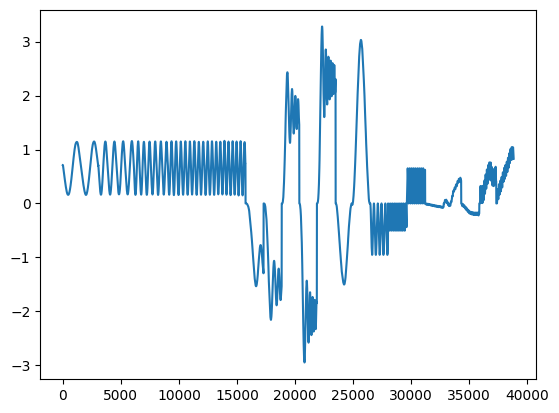

In [38]:
plt.figure()
plt.plot(test_data[:,6])


<Figure size 800x400 with 0 Axes>

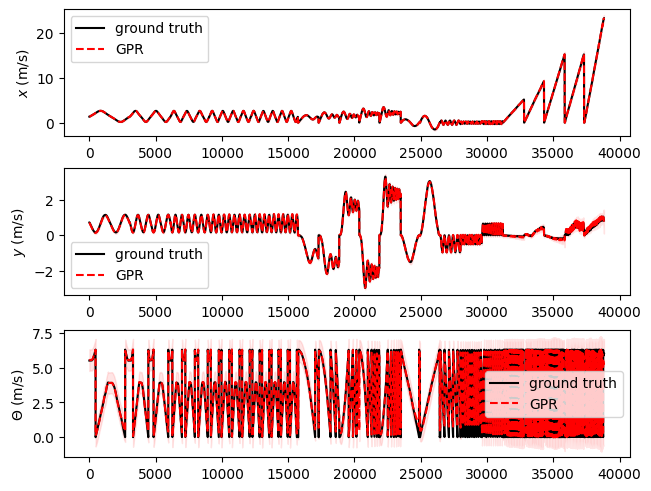

In [39]:

plt.figure(figsize=(8,4))

f, axs = plt.subplots(3, 1, layout='constrained')

axs[0].plot(test_data[:,5],label='ground truth',color='k')
axs[0].plot(y_pred.numpy()[:,0], color = 'red', label = 'GPR', linestyle = '--')
x_plot = np.linspace(0, len(y_pred), len(y_pred))

axs[0].fill_between(x_plot,lower.numpy()[:,0], upper.numpy()[:,0], alpha = 0.1, color = 'red')
axs[0].legend()
#ax1.xlabel('Time')
axs[0].set_ylabel('$x$ (m/s)')


axs[1].plot(test_data[:,6],label='ground truth',color='k')
axs[1].plot(y_pred.numpy()[:,1], color = 'red', label = 'GPR', linestyle = '--')
#x_plot = np.linspace(0, len(y_pred), len(y_pred))

axs[1].fill_between(x_plot,lower.numpy()[:,1], upper.numpy()[:,1], alpha = 0.1, color = 'red')
axs[1].legend()
#ax2.xlabel('Time')
axs[1].set_ylabel('$y$ (m/s)')

axs[2].plot(test_data[:,7],label='ground truth',color='k')
axs[2].plot(y_pred.numpy()[:,2], color = 'red', label = 'GPR', linestyle = '--')
#x_plot = np.linspace(0, len(y_pred), len(y_pred))

axs[2].fill_between(x_plot,lower.numpy()[:,2], upper.numpy()[:,2], alpha = 0.1, color = 'red')
axs[2].legend()
#ax3.xlabel('Time')
axs[2].set_ylabel('$\Theta$ (m/s)')
plt.show()

In [40]:
def upper_confidence_bound(y_pred, lower, upper, lbda):
    ucb_x = y_pred.numpy()[:,0] + lbda*(upper.numpy()[:,0] - lower.numpy()[:,0])/2
    ucb_y = y_pred.numpy()[:,1] + lbda*(upper.numpy()[:,1] - lower.numpy()[:,1])/2
    ucb_theta = y_pred.numpy()[:,2] + lbda*(upper.numpy()[:,2] - lower.numpy()[:,2])/2

    ucb_x = ucb_x.reshape((-1,1))
    ucb_y = ucb_y.reshape((-1,1))
    ucb_theta = ucb_theta.reshape((-1,1))

    ucb = np.hstack((ucb_x, ucb_y, ucb_theta))

    ucb = np.amax(ucb, axis = 1)

    #ucb = (ucb_x + ucb_y + ucb_theta)/3
    # jx = np.argmax(ucb_x, axis=0)
    # jy = np.argmax(ucb_y, axis=0)
    # jtheta = np.argmax(ucb_theta, axis=0)
    j = np.argmax(ucb)
    return j, ucb

def rmse(y_pred, test_data=test_data[:,5:8]):
    err = np.sqrt(((y_pred.numpy()- test_data)**2).mean(axis=0))
    return err

RMSE_no_AL = rmse(y_pred=y_pred, test_data=test_data[:,5:8])
print(RMSE_no_AL)

[0.01836335 0.02242841 0.46149499]


## Upper Confidence Bound Acquisition Function

<Figure size 2000x400 with 0 Axes>

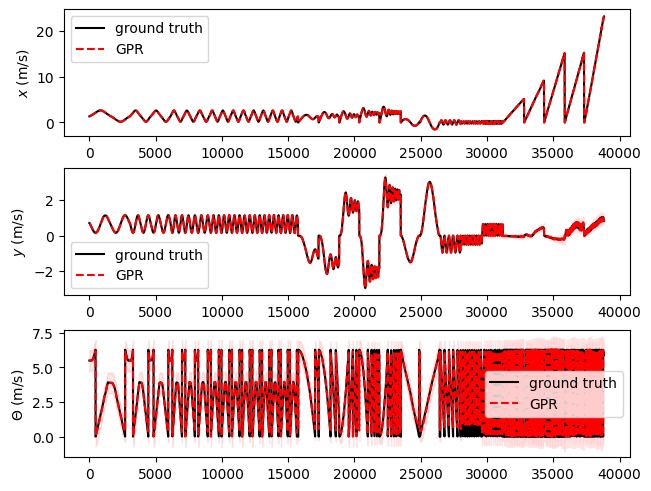

In [41]:
# set how many loops to train
n_loops = 10
lbda = 2

x_train = miniset[:,0:5]
y_train = miniset[:,5:8]

x_plot = np.linspace(0, len(y_pred)-1, len(y_pred))
x_acq = []
y_acq = []

points = []

for i in range(n_loops):



    j, ucb = upper_confidence_bound(y_pred, lower, upper, lbda = lbda)

    points.append(j)
    
    x_new = X_test[j,:].numpy().reshape((1,-1))
    y_new = Y_test[j,:].numpy().reshape((1,-1))
    x_acq.append(x_plot[j]) 
    y_acq.append(y_new[0,0])

    x_train = np.vstack((x_train, x_new))
    y_train = np.vstack((y_train, y_new))
    X_train = torch.from_numpy(x_train)
    Y_train = torch.from_numpy(y_train)

    # Retrain Model
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
    model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
    model = train_model(model)

    # Evaluate Model
    y_pred, lower, upper = model_predict(model, X_test)




plt.figure(figsize=(20,4))

f, axs = plt.subplots(3, 1, layout='constrained')

axs[0].plot(test_data[:,5],label='ground truth',color='k')
axs[0].plot(y_pred.numpy()[:,0], color = 'red', label = 'GPR', linestyle = '--')
x_plot = np.linspace(0, len(y_pred), len(y_pred))

axs[0].fill_between(x_plot,lower.numpy()[:,0], upper.numpy()[:,0], alpha = 0.1, color = 'red')
axs[0].legend()
#ax1.xlabel('Time')
axs[0].set_ylabel('$x$ (m/s)')


axs[1].plot(test_data[:,6],label='ground truth',color='k')
axs[1].plot(y_pred.numpy()[:,1], color = 'red', label = 'GPR', linestyle = '--')
#x_plot = np.linspace(0, len(y_pred), len(y_pred))

axs[1].fill_between(x_plot,lower.numpy()[:,1], upper.numpy()[:,1], alpha = 0.1, color = 'red')
axs[1].legend()
#ax2.xlabel('Time')
axs[1].set_ylabel('$y$ (m/s)')

axs[2].plot(test_data[:,7],label='ground truth',color='k')
axs[2].plot(y_pred.numpy()[:,2], color = 'red', label = 'GPR', linestyle = '--')
#x_plot = np.linspace(0, len(y_pred), len(y_pred))

axs[2].fill_between(x_plot,lower.numpy()[:,2], upper.numpy()[:,2], alpha = 0.1, color = 'red')
axs[2].legend()
#ax3.xlabel('Time')
axs[2].set_ylabel('$\Theta$ (m/s)')
plt.show()

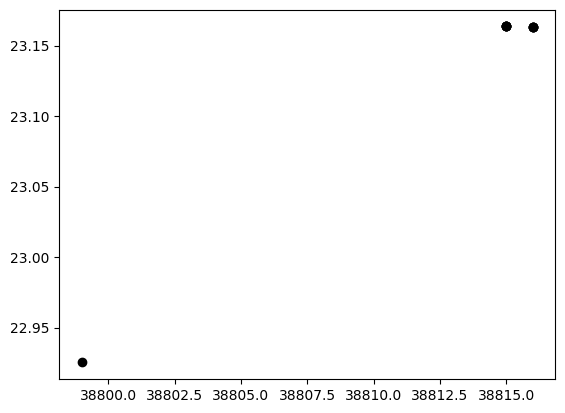

In [42]:
plt.figure()
plt.scatter(np.array(x_acq), np.array(y_acq), color="k")

In [43]:
print(x_acq)
print(y_acq)

[38816.0, 38816.0, 38816.0, 38815.0, 38815.0, 38815.0, 38815.0, 38816.0, 38815.0, 38799.0]
[23.16342, 23.16342, 23.16342, 23.16355, 23.16355, 23.16355, 23.16355, 23.16342, 23.16355, 22.92528]


In [44]:
print(points)

[38816, 38816, 38816, 38815, 38815, 38815, 38815, 38816, 38815, 38799]


In [25]:
RMSE_UCB = rmse(y_pred=y_pred, test_data=test_data[:,5:8])
print(RMSE_UCB)

[0.03717674 0.02130346 0.46108408]


In [ ]:
j = np.argmax(ucb)
print(j)

## Probability of Improvement Acquisition Function

In [ ]:
def POI(y_pred,lower,upper,epsilon):
    y_best = np.amax(y_pred.numpy(), axis=0)
    PIx = np.empty(y_pred.numpy().size,dtype=float)
    PIy = np.empty(y_pred.numpy().size,dtype=float)
    PItheta = np.empty(y_pred.numpy().size,dtype=float)
    sigma_x = (upper.numpy()[:,0] - lower.numpy()[:,0])/2
    sigma_y = (upper.numpy()[:,1] - lower.numpy()[:,1])/2
    sigma_theta = (upper.numpy()[:,2] - lower.numpy()[:,2])/2
    for i in range(0,y_pred.numpy().size):
        if sigma_x[i] > 1e-4:
            zzx = (y_pred.numpy()[i,0]-y_best-epsilon)/sigma_x[i]
            PIx[i] = norm.cdf(zzx)
        else:
            PIx[i] = 0.0

        if sigma_y[i] > 1e-04:
            zzy = (y_pred.numpy()[i,1]-y_best-epsilon)/sigma_y[i]
            PIy[i] = norm.cdf(zzy)
        else:
            PIx[i] = 0.0

        if sigma_theta[i] > 1e-04:
            zztheta = (y_pred.numpy()[i,2]-y_best-epsilon)/sigma_theta[i]
            PItheta[i] = norm.cdf(zztheta)
        else:
            PItheta[i] = 0.0
    PI = (PIx + PIy + PItheta)/3    
    loc = PI.argmax()
    return PI, loc

poi, loc = POI(y_pred = y_pred,lower = lower,upper = upper,epsilon = 0.1)

In [ ]:
y_best = np.amax(y_pred.numpy(), axis=0)
y_best.shape

### Reinitialize and Retrain Model

In [ ]:
miniset = generate_initial_dataset(data=data, Ni = 10, set_seed=1)
X_train = torch.from_numpy(miniset[:,0:2])
Y_train = torch.from_numpy(miniset[:,2:3])
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
model = train_model(model)
y_pred, lower, upper = model_predict(model, X_test)

In [ ]:
# set how many loops to train
n_loops = 20

x_train = miniset[:,0:2]
y_train = miniset[:,2:3]

x_plot = np.linspace(0, len(y_pred), len(y_pred))
x_acq = []
y_acq = []

for i in range(n_loops):

    poi, loc = POI(y_pred = y_pred,lower = lower,upper = upper,epsilon = 0.1)
    
    x_new = X_test[loc,:].numpy().reshape((1,-1))
    y_new = Y_test[loc,:].numpy().reshape((1,-1))
    x_acq.append(x_plot[loc]) 
    y_acq.append(y_new[0,0])

    x_train = np.vstack((x_train, x_new))
    y_train = np.vstack((y_train, y_new))
    X_train = torch.from_numpy(x_train)
    Y_train = torch.from_numpy(y_train)

    # Retrain Model
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
    model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
    model = train_model(model)

    # Evaluate Model
    y_pred, lower, upper = model_predict(model, X_test)



plt.figure(figsize=(8,4))
plt.plot(test_data[:,2],label='ground truth',color='k')

plt.plot(y_pred.numpy(), color = 'red', label = 'GPR', linestyle = '--')
plt.fill_between(x_plot,lower.numpy()[:,0], upper.numpy()[:,0], alpha = 0.1, color = 'red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$V_x$ (m/s)')
plt.show()

In [ ]:
plt.figure()
plt.scatter(np.array(x_acq), np.array(y_acq), color="k")

In [ ]:
RMSE_POI = rmse(y_pred=y_pred, test_data=test_data[:,2])
print(RMSE_POI)

## Expected Improvement Acquisition Function

In [ ]:
def Exp_Imp(y_pred, lower, upper, epsilon):
    EI = np.empty(y_pred.numpy().size,dtype=float)
    y_best = y_pred.numpy().max()
    sigma = (upper.numpy()[:,0] - lower.numpy()[:,0])/2
    for i in range(0,y_pred.numpy().size):
        if sigma[i] > 1e-4:
            zz = (y_pred[i]-y_best-epsilon)/sigma[i]
            EI[i] = (y_pred[i]-y_best-epsilon)*norm.cdf(zz,scale=1)+sigma[i]*norm.pdf(zz,scale=1)
        else:
            EI[i] = 0.0
    loc = EI.argmax()
    return EI, loc

### Reinitialize and Retrain Model

In [ ]:
miniset = generate_initial_dataset(data=data, Ni = 10, set_seed=1)
X_train = torch.from_numpy(miniset[:,0:2])
Y_train = torch.from_numpy(miniset[:,2:3])
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
model = train_model(model)
y_pred, lower, upper = model_predict(model, X_test)

In [ ]:
# set how many loops to train
n_loops = 20

x_train = miniset[:,0:2]
y_train = miniset[:,2:3]

x_plot = np.linspace(0, len(y_pred), len(y_pred))
x_acq = []
y_acq = []

for i in range(n_loops):

    expi, loc = Exp_Imp(y_pred = y_pred,lower = lower,upper = upper,epsilon =0.1)
    
    x_new = X_test[loc,:].numpy().reshape((1,-1))
    y_new = Y_test[loc,:].numpy().reshape((1,-1))
    x_acq.append(x_plot[loc]) 
    y_acq.append(y_new[0,0])

    x_train = np.vstack((x_train, x_new))
    y_train = np.vstack((y_train, y_new))
    X_train = torch.from_numpy(x_train)
    Y_train = torch.from_numpy(y_train)

    # Retrain Model
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
    model = BatchIndependentMultitaskGPModel(X_train, Y_train, likelihood)
    model = train_model(model)

    # Evaluate Model
    y_pred, lower, upper = model_predict(model, X_test)



plt.figure(figsize=(8,4))
plt.plot(test_data[:,2],label='ground truth',color='k')

plt.plot(y_pred.numpy(), color = 'red', label = 'GPR', linestyle = '--')
plt.fill_between(x_plot,lower.numpy()[:,0], upper.numpy()[:,0], alpha = 0.1, color = 'red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$V_x$ (m/s)')
plt.show()

In [ ]:
plt.figure()
plt.scatter(np.array(x_acq), np.array(y_acq), color="k")

In [ ]:
RMSE_EI = rmse(y_pred=y_pred, test_data=test_data[:,2])
print(RMSE_EI)

In [ ]:
# import datetime

# t = tuple(map(int, c[0].split('_')))

# print(t)

In [ ]:
import numpy as np
a = np.random.rand(5,2)
b = np.random.rand(5,2)
print(a)
print(b)
a0 = a[:,0]
b0 = b[:,0]

c = (np.sqrt(((a-b)**2)).mean(axis=0))
d = (np.sqrt(((a0-b0)**2)).mean())
print(c)
print(d)
